In [239]:
import sys
sys.path.append("./../..")

from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle

from scipy.optimize import curve_fit
from scipy.stats import chisquare 

In [240]:
dt = 1e-6
Sample_frequency = 25_000 
DeltaT = 1/Sample_frequency  
TotalT = 13
transient = 3
EffectiveT = TotalT - transient

sampled_point_amount = np.int64((EffectiveT)/DeltaT) 
t = np.linspace(0., EffectiveT, sampled_point_amount) 

print("Effective simulation time: %d (s)" % EffectiveT)

Effective simulation time: 10 (s)


In [241]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [242]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

As a reference, here's a part of the function we called to compute the summary statistics on cloud. 

```python
def compute_summary_statistics(single_x_trace, single_theta, DeltaT = 1/25e3, TotalT = 10):
    summary_statistics = {}
    t = np.linspace(0., TotalT, single_x_trace.shape[0])
    t_corr = TotalT/20 # Hyperparameter
    
    [...]

    # Autocorrelation
    Cxx = stat_corr_single(single_x_trace, DeltaT)
    idx_corr = where((t>0)*(t<t_corr))[0]
    cxx = Cxx[idx_corr]
    summary_statistics["Cxx"] = cxx  
    
    # S red
    S_red1, S_red2, S_red = stat_s_redx(Cxx, t_corr, t)
    summary_statistics["s_red1"] = S_red1
    summary_statistics["s_red2"] = S_red2
    summary_statistics["s_redx"] = S_red 

    [...]
    
    return summary_statistics
```

In [243]:
%%time
n_sim = 10
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient)

CPU times: user 1min 2s, sys: 19.2 ms, total: 1min 2s
Wall time: 1min 1s


In [244]:
print("X_trace shape: ", x_trace.shape)
print("theta shape: ", theta.shape)

X_trace shape:  (10, 249999)
theta shape:  (5, 10, 1)


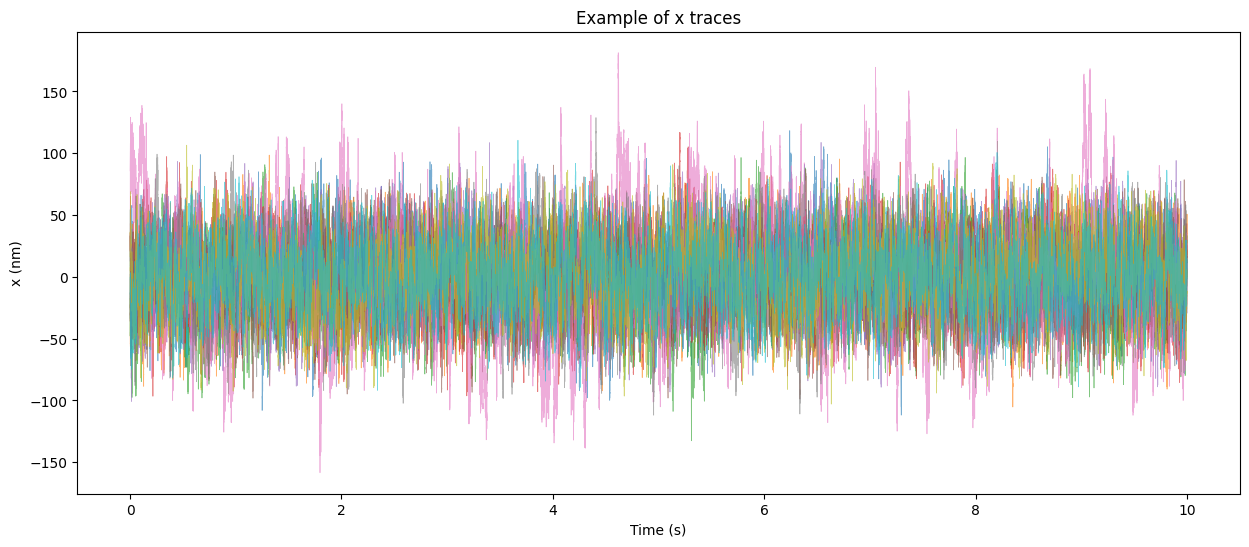

In [245]:
plt.figure(figsize=(15, 6))
plt.title("Example of x traces")
for i in range(n_sim):
    plt.plot(t, x_trace[i], alpha=0.6, lw=0.5)
plt.xlabel("Time (s)")
plt.ylabel("x (nm)");

In [246]:
# Hyperparameters of the statistical functions
## Remember that TotalT does include the transient time
## Note that if t_corr > EffectiveT, idx_corr will be the same as t
t_corr = TotalT/20

# Lists to store the results
Cxx_list = []
s_red1_list = []
s_red2_list = []
s_redx_list = []

# Iterate over the simulations
for i in range(n_sim):
    ## Note that Cxx is cutted after the computation the s_redx
    ## Instead, s_redx is cutted inside stat_ the function
    Cxx = stat_corr_single(x_trace[i], DeltaT)
    
    ## The following line sets Cxx to zero when below a certain threshold
    #Cxx[where(Cxx < 5)[0][0]:] = 0

    idx_corr = where((t>0)*(t<t_corr))[0]
    
    s_red1, s_red2, s_redx = stat_s_redx(Cxx, t_corr, t)
    
    Cxx_list.append(Cxx[idx_corr])
    s_red1_list.append(s_red1)
    s_red2_list.append(s_red2)
    s_redx_list.append(s_redx)

In [247]:
# Define the t_cxx array
t_cxx = t[where((t>0)*(t<t_corr))[0]]
t_cxx[-1]

0.6499651997215978

In [248]:
print(len(s_red1))

16249


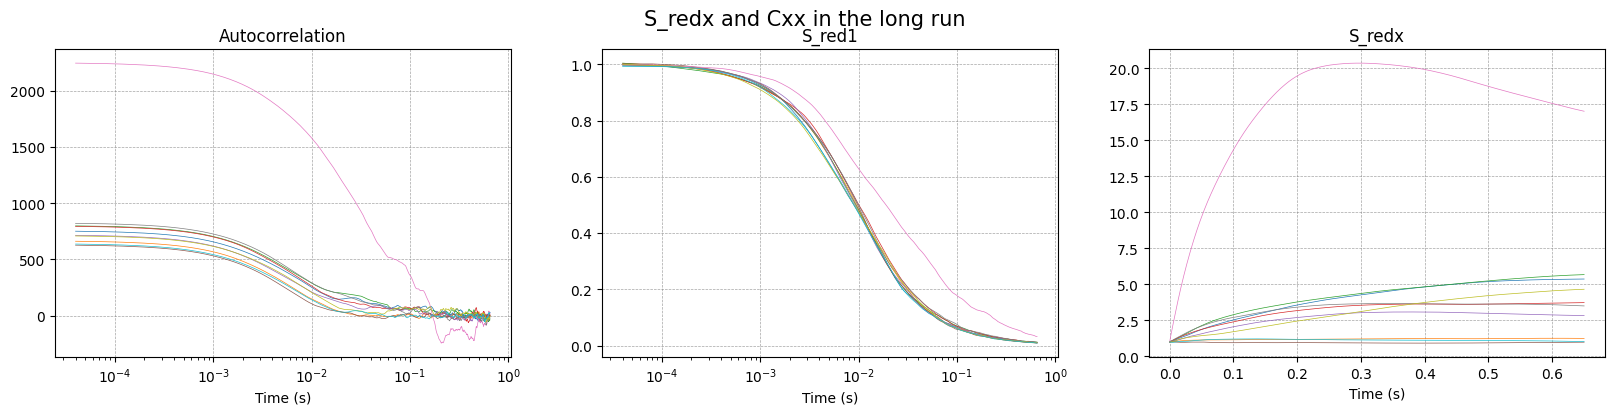

In [249]:
plt.figure(figsize=(20, 4))
plt.suptitle("S_redx and Cxx in the long run", fontsize=15)

plt.subplot(131)
plt.title("Autocorrelation")
for i in range(n_sim):
    plt.plot(t_cxx, Cxx_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
#plt.yscale("log")
#plt.xlim(0, 0.9)
#plt.ylim(0, 1000)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(132)
plt.title("S_red1")
for i in range(n_sim):
    plt.plot(t_cxx, s_red1_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(133)
plt.title("S_redx")
for i in range(n_sim):
    plt.plot(t_cxx, s_redx_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
#plt.xscale("log")
#plt.yscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')


In [257]:
def stat_fit_s_redx(single_s_redx, single_corr, DeltaT, mode="exp"):
    """
    Fit the s_redx function
    """
    assert mode in ["exp", "simple"], "Mode not recognized"

    n = len(single_s_redx)
    t_cxx = np.linspace(0., (n+1)*DeltaT, (n+1))[1:]
    
    def s_redx_simple(t, a, tau):
        return(1 + a*t/(1+t/tau))

    def s_redx_exp(t, a1, a2, b1, b2, b3, c):
        a3 = 1 - a1 - a2 
        sum_exp = a1*np.exp(-b1*t) + (a2)*np.exp(-(b1+b2)*t) + (a3)*np.exp(-(b1+b2+b3)*t)
        sum = a1*b1 + (a2)*(b1+b2) + (a3)*(b1+b2+b3)
        tau = 1/sum
        return(1 + c - (c*tau/t)*(1-sum_exp))
    
    if mode == "exp":
        # Cut based on the decay of Cxx
        # Get the first index for which Cxx < Cxx[0]/2
        idx_tau = np.where(single_corr < single_corr[0]/np.e)[0][0]
        # Cut s_redx and t_cxx
        cut = np.min([n-1, 6*idx_tau])
        print(len(single_corr), idx_tau, t_cxx[idx_tau], t_cxx[cut])
        t_cxx_fit = t_cxx[:cut]
        single_s_redx_fit = single_s_redx[:cut]


        # Cut based on the max of s_redx
        # idx_max = np.argmax(single_s_redx)
        # idx_tau = np.where(single_corr < single_corr[0]/np.e)[0][0]
        
        # cut = np.int32(np.min([n, idx_max + 5*idx_tau])) # x*idx_tau is a heuristic factor
        # t_cxx_fit = t_cxx[:cut]
        # print(t_cxx_fit[-1], t_cxx[-1])
        # single_s_redx_fit = single_s_redx[:cut]
        # print(len(t_cxx), len(single_s_redx_fit))
        
        # # Linear sample (to reduce complexity)
        #t_cxx_fit = t_cxx_fit[::6]
        #single_s_redx_fit = single_s_redx_fit[::6]
        
        try: 
            popt, pcov = curve_fit(s_redx_exp, t_cxx_fit, single_s_redx_fit, p0=[1, 10, 10, 0.1, 0.01, 10],
                          bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]), maxfev=5000)
            #print(chisquare(single_s_redx_fit, s_redx_exp(t_cxx_fit, *popt)))
        except:
            return np.zeros(6), np.zeros(len(t_cxx))
        return popt, s_redx_exp(t_cxx, *popt)

    if mode == "simple":
        t_cxx_fit = t_cxx[::6]
        single_s_redx_fit = single_s_redx[::6]
        try:
            popt, pcov = curve_fit(s_redx_simple, t_cxx_fit, single_s_redx_fit, p0=[1e3, 1e-2],
                          bounds=([0, 0], [np.inf, np.inf]), maxfev=5000)
        except:
            return np.zeros(6), np.zeros(len(t_cxx))
        return popt, s_redx_simple(t_cxx, *popt)

16249 226 0.009080558803618684 0.054283340513262356
[0.999996, 0.377619, 0.785667, 371.126709, 0.003692, 45.160959]
16249 164 0.006600406178841775 0.0394024247646009
[0.001722, 64.089746, 0.000876, 175.97929, 1.32671, 0.182587]
16249 245 0.009840605575727739 0.05884362114591667
[1.342167, 14.10942, 27.706193, 1.988077, 0.623451, 3.933791]
16249 223 0.008960551418548835 0.05356329620284326
[0.994053, 1.3012, 6.732574, 70.109517, 0.0, 4.638559]
16249 197 0.007920487414610131 0.04732291217921103
[2e-06, 17.394452, 59.551707, 3.211723, 1.669133, 1.147479]


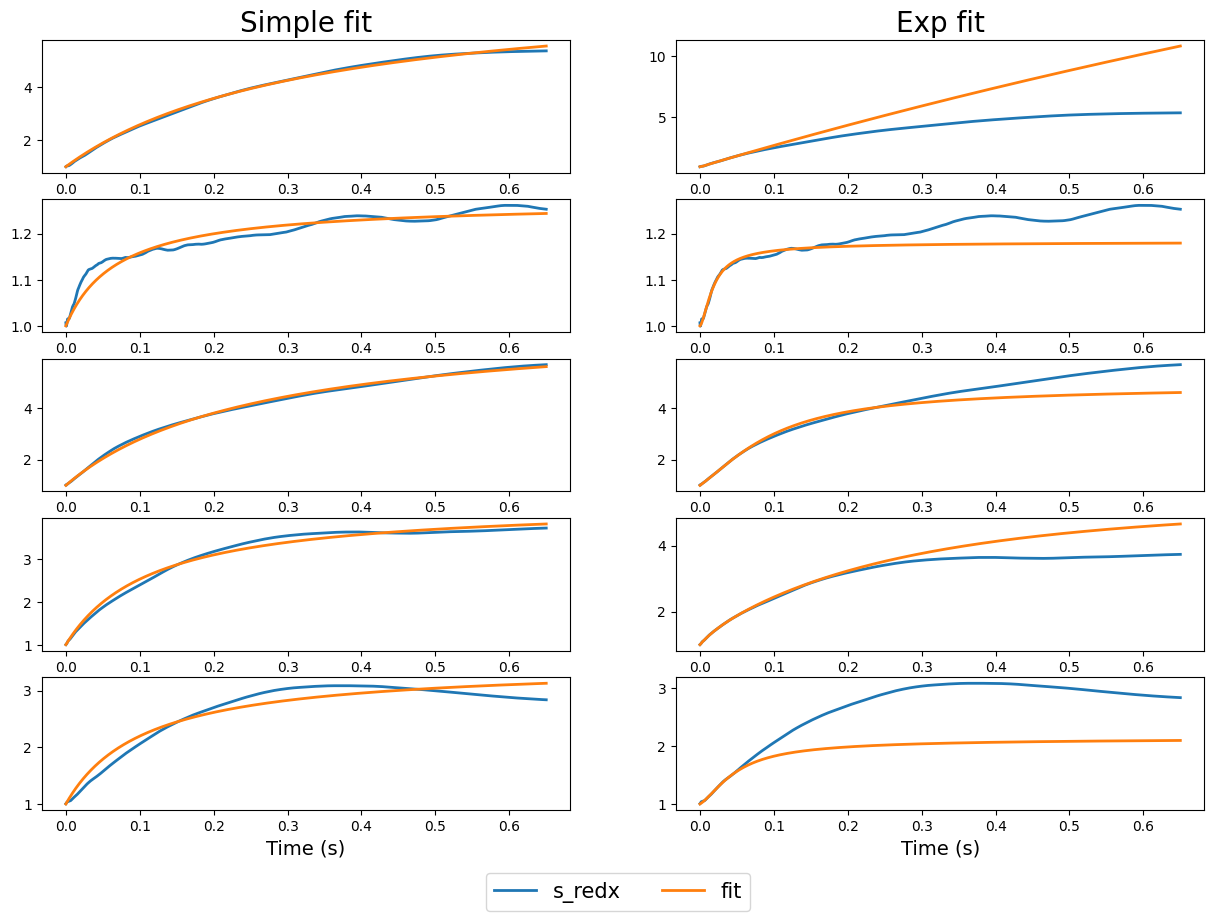

In [258]:
# Fit and plot s_redx
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
ax = ax.ravel()

# p0=[1, 10, 10, 0.1, 0.1, 10]

for i in range(5):
    popt, fit_simple = stat_fit_s_redx(s_redx_list[i], Cxx_list[i], DeltaT, mode="simple")
    popt2, fit_exp = stat_fit_s_redx(s_redx_list[i], Cxx_list[i], DeltaT, mode="exp")
    print([round(p, 6) for p in popt2])
    
    if i == 0: 
       ax[2*i].plot(t_cxx, s_redx_list[i], lw=2, label="s_redx")
       ax[2*i].plot(t_cxx, fit_simple, lw=2, label="fit")
       ax[2*i].set_title("Simple fit", fontsize=20)
    else:
       ax[2*i].plot(t_cxx, s_redx_list[i], lw=2)
       ax[2*i].plot(t_cxx, fit_simple, lw=2)
    ax[2*i].set_xlabel("Time (s)", fontsize=14)
    
    if i == 0: ax[2*i+1].set_title("Exp fit", fontsize=20)
    ax[2*i+1].plot(t_cxx, s_redx_list[i], lw=2)
    ax[2*i+1].plot(t_cxx, fit_exp, lw=2)
    ax[2*i+1].set_xlabel("Time (s)", fontsize=14)

fig.legend(loc=(0.4, 0.01), fontsize=15, ncol=2)
#fig.tight_layout()

In [252]:
def stat_fit_corr(single_corr, DeltaT):
    # Get the temporal array
    n = len(single_corr)
    t_cxx = np.arange(0., n*DeltaT, DeltaT)[1:]

    def cxx_exp3(t, a1, a2, a3, b1, b2, b3):
        return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)
    
    # Log sample Cxx and t_cxx
    log_sample = np.logspace(0, np.log10(n-1), 100, dtype=np.int32)
    t_cxx_log = t_cxx[log_sample]
    single_corr_log = single_corr[log_sample]

    popt, pcov = curve_fit(cxx_exp3, t_cxx_log, single_corr_log, p0=[1, 1, 1, 1, 1, 1], maxfev=5000)

    return popt, cxx_exp3(t_cxx, *popt)

/tmp/ipykernel_22140/2829841125.py:7: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)


[566.82747, 61.701003, 125.726837, 178.00399, 42.288786, 5.694006]
[304.397877, 301.640318, 60.61691, 141.187215, 141.191275, 388.057388]
[234.10256, 50.569268, 520.397443, 24.794924, 2.990038, 205.789192]
[13.515399, 651.917981, 133.224359, 570.80942, 152.494743, 10.3876]
[30.147076, 569.878259, 119.805986, 507.712199, 168.462824, 11.16955]


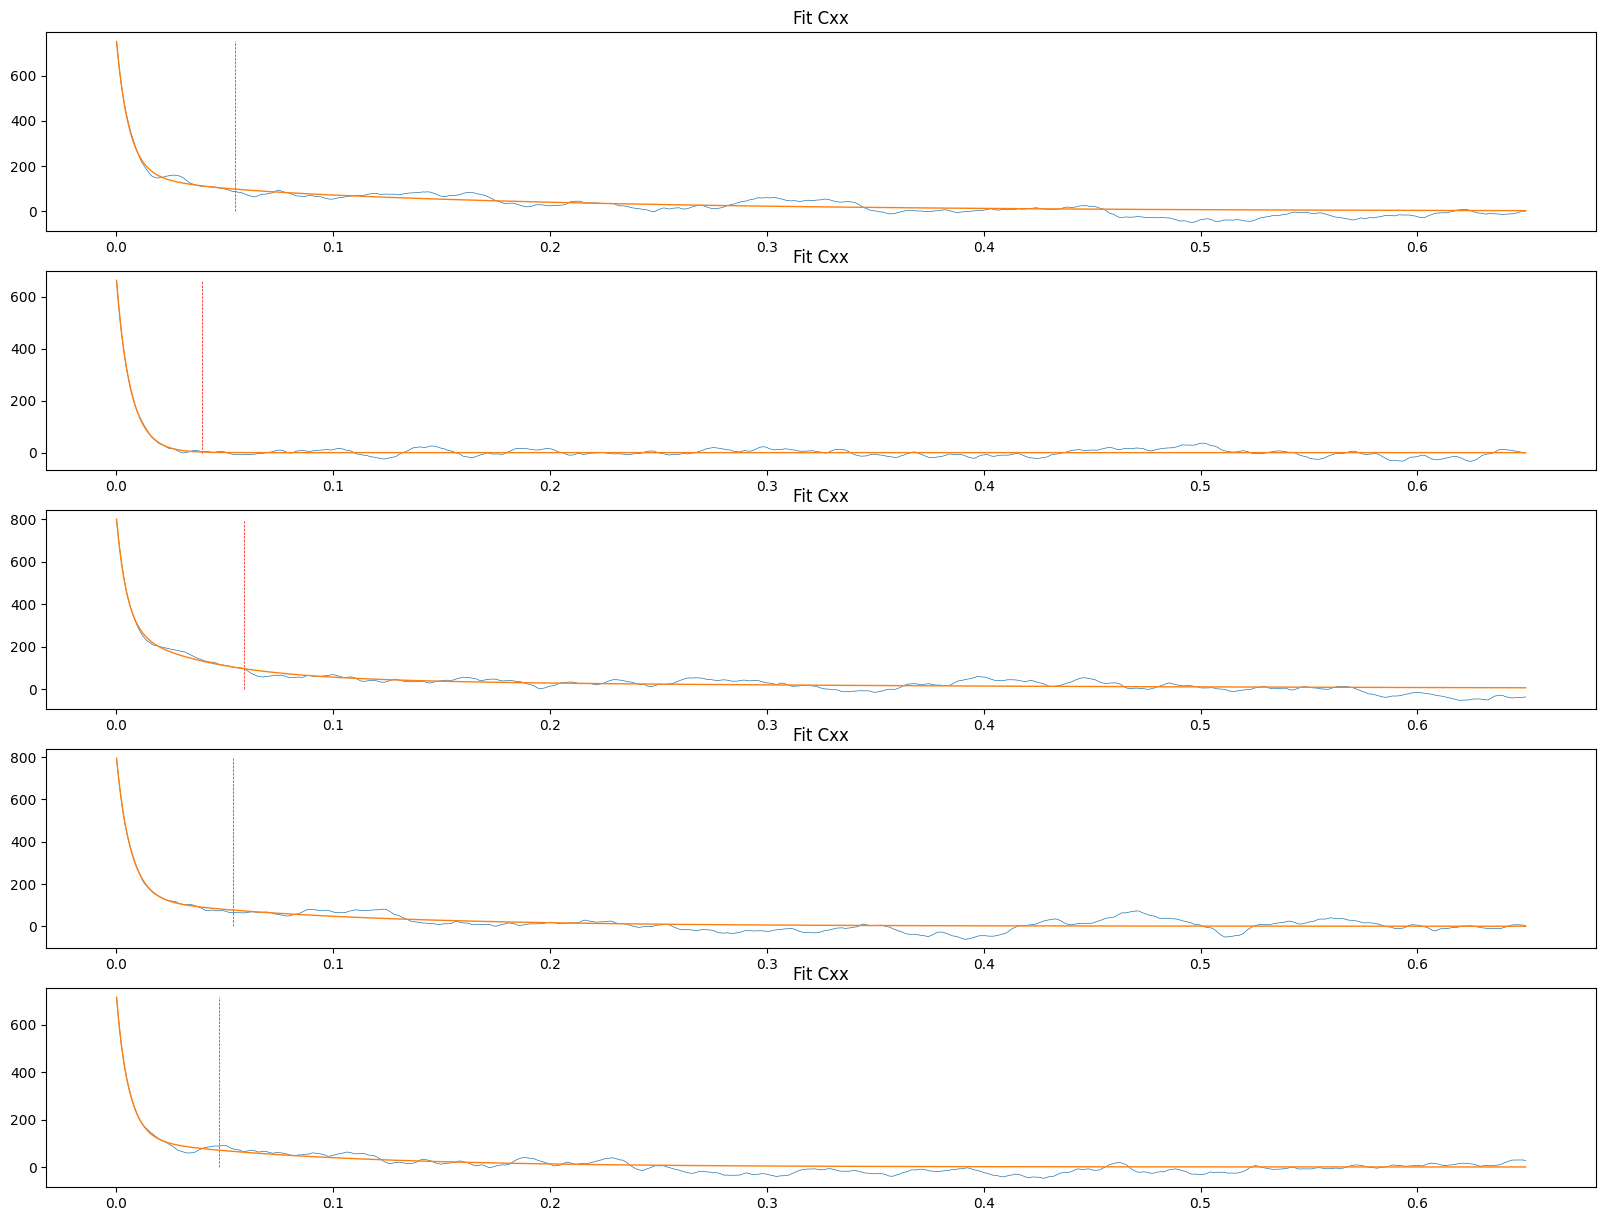

In [260]:
# Fit and plot Cxx
fig, ax = plt.subplots(5, 1, figsize=(20, 15))
ax = ax.ravel()

for i in range(5):
    idx = np.where(Cxx_list[i] < Cxx_list[i][0]/np.e)[0][0]
    ax[i].vlines(6*t_cxx[idx], 0, Cxx_list[i][0], linestyle="--", color="red", lw=0.5)
    
    popt, fit_cxx = stat_fit_corr(Cxx_list[i], DeltaT)
    print([round(p, 6) for p in popt])
    ax[i].plot(t_cxx, Cxx_list[i], lw=0.5)
    ax[i].plot(t_cxx, fit_cxx, lw=1)
    ax[i].set_title("Fit Cxx")
